In [1]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)
 
%load_ext autoreload
%autoreload 2

In [59]:
import pandas as pd
import numpy as np

import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(palette='pastel')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)
pl.Config.set_tbl_cols(-1)

COLUMNAS_PROCEDIMIENTOS = [f"PROCEDIMIENTO{i}" for i in range(1, 31)]

In [21]:
# Lee la base de GRD del Torax
df_torax = (
    pl.scan_csv("../data/processed/df_procesada.csv", separator=";", infer_schema_length=0)
    .filter((pl.col("COD_HOSPITAL") == "112103") & (pl.col("TIPO_ACTIVIDAD") == "HOSPITALIZACIÓN"))
    .cast({"ESTANCIA": pl.Int32})
    .collect()
)

In [51]:
# Codigos de Trasplante pulmon unilateral, bilateral y cardiaco, respectivamente
CODIGOS_TRASPLANTE = ["33.51", "33.52", "37.51"]

# Obtiene todos los egresos donde el procedimiento 1 sea un trasplante
df_trasplantes = df_torax.filter(pl.col("PROCEDIMIENTO1").is_in(CODIGOS_TRASPLANTE))

# Obtiene el resumen de dias de estada para cada trasplante
resumen_estancia_trasplantes = (
    df_trasplantes.group_by(["ANIO_EGRESO", "PROCEDIMIENTO1"])
    .agg(
        [
            pl.col("ESTANCIA").sum().alias("dias_estada_totales"),
            pl.len().alias("n_egresos"),
            pl.col("ESTANCIA").mean().alias("dias_estada_promedio"),
            pl.col("CIP_ENCRIPTADO").n_unique().alias("cantidad_de_pacientes")
        ]
    )
    .sort(["PROCEDIMIENTO1", "ANIO_EGRESO"])
    .to_pandas()
)

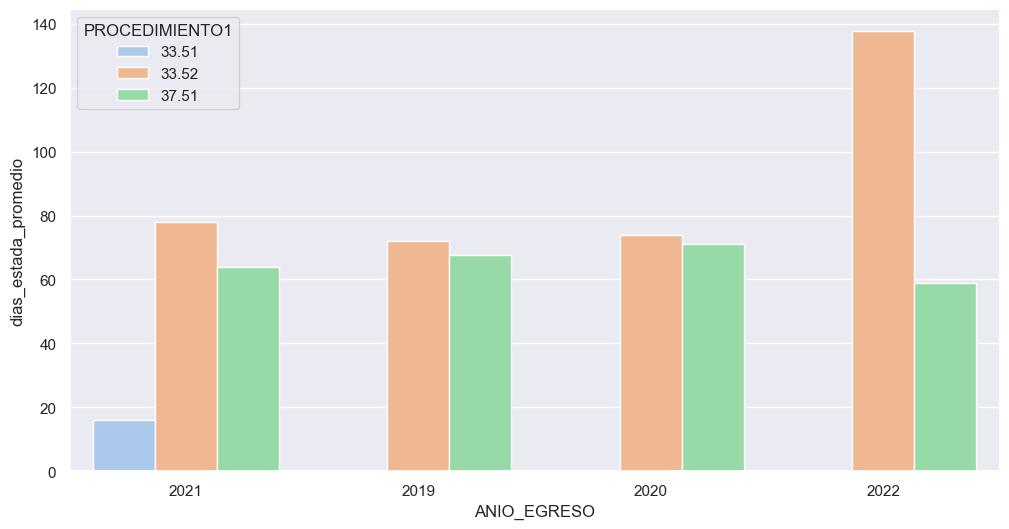

In [50]:
# Grafica resumen de dias de estada por tipo de trasplante
ax = sns.barplot(
    resumen_estancia_trasplantes, x="ANIO_EGRESO", y="dias_estada_promedio", hue="PROCEDIMIENTO1"
)
plt.show()

In [90]:
# Convierte el DataFrame de polars a pandas
df_torax_pandas = df_torax.to_pandas()

# Busca en todos los procedimientos (desde el 1 al 30) si es que hay un codigo de trasplante
trasplantes_en_todos_los_proc = df_torax_pandas[
    df_torax_pandas[COLUMNAS_PROCEDIMIENTOS].isin(CODIGOS_TRASPLANTE).sum(axis=1).astype(bool)
]

# Indica el largo del DataFrame al buscar los procedimientos de trasplante en todas las cols de proc
print(trasplantes_en_todos_los_proc.shape)

(60, 137)


Como el largo del DataFrame al buscar solamente en el `PROCEDIMIENTO1` y en todos los ``PROCEDIMIENTOS`` es el mismo, entonces los codigos de trasplante solo se ponen en el ``PROCEDIMIENTO1``. 